In [19]:
# Github trends analysis starter
import requests
import html
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# Github search API
# https://docs.github.com/en/rest/reference/search#search-repositories
github_url = 'https://api.github.com/search/repositories'


In [38]:
# construct search query
q = '"Hult" created:2020-09-01..2021-06-01'

# MODIFY the query: add keywords of your interest, for example
#q = '"business analytics" created:2020-09-..2021-06-01'

In [39]:
# request parameters
qparams = {'q' : q, 'sort' : 'stars', 'order': 'desc', 'per_page' : 100}

In [40]:
# review class session on working with APIs
r = requests.get(url=github_url, params=qparams)
r

<Response [200]>

In [41]:
res = r.json()
res.keys()

dict_keys(['total_count', 'incomplete_results', 'items'])

In [42]:
# items returned in the response (first page)
len(res['items'])

75

In [43]:
# inspects results item structure
res['items'][2]

{'id': 296151695,
 'node_id': 'MDEwOlJlcG9zaXRvcnkyOTYxNTE2OTU=',
 'name': 'hultprizeindia-backend',
 'full_name': 'HultPrizeIndia/hultprizeindia-backend',
 'private': False,
 'owner': {'login': 'HultPrizeIndia',
  'id': 69625320,
  'node_id': 'MDEyOk9yZ2FuaXphdGlvbjY5NjI1MzIw',
  'avatar_url': 'https://avatars.githubusercontent.com/u/69625320?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/HultPrizeIndia',
  'html_url': 'https://github.com/HultPrizeIndia',
  'followers_url': 'https://api.github.com/users/HultPrizeIndia/followers',
  'following_url': 'https://api.github.com/users/HultPrizeIndia/following{/other_user}',
  'gists_url': 'https://api.github.com/users/HultPrizeIndia/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/HultPrizeIndia/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/HultPrizeIndia/subscriptions',
  'organizations_url': 'https://api.github.com/users/HultPrizeIndia/orgs',
  'repos_url': 'https://api.git

In [44]:
res['items'][2]['description']

'A RESTful API with JWT, Integration Testing, and GitHub actions. Built using node.js, express, and mongo.'

In [45]:
# total number of top repositories collected
len(res['items'])

75

In [46]:
stop_words = set(stopwords.words('english'))

# text cleaning function
def text_cleanup(s):
    # if not a string object, disregard
    if not isinstance(s, str):
        return ''
    
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and w.isalnum()]
    
    # return clean string
    return ' '.join(wt_filt)

In [47]:
# clean text of repository descriotions
text_cleanup(res['items'][2]['description'])

'restful api jwt integration testing github actions built using express mongo'

In [48]:
# list of cleaned-up top repository description strings
descr = [text_cleanup(r['description']) for r in res['items']]

In [49]:
# NLTK collocations search (words occuring together): bigrams
# https://www.nltk.org/howto/collocations.html
# http://www.nltk.org/api/nltk.html#nltk.util.bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in descr])

In [50]:
# filter out bigrams occurring less than three times in the combined text
bigram_finder.apply_freq_filter(3)

In [51]:
# list of bigrams with their frequencies
bigram_freq = list(bigram_finder.ngram_fd.items())
bigram_freq

[(('text', 'analytics'), 3),
 (('course', 'hult'), 7),
 (('hult', 'international'), 21),
 (('international', 'business'), 22),
 (('business', 'school'), 23),
 (('business', 'analytics'), 10),
 (('analytics', 'hult'), 9),
 (('final', 'project'), 3),
 (('project', 'individual'), 5),
 (('curricular', 'course'), 8),
 (('course', 'attended'), 8),
 (('attended', 'throughout'), 7),
 (('throughout', 'fall'), 6),
 (('fall', 'semester'), 6),
 (('semester', 'second'), 7),
 (('second', 'master'), 7),
 (('master', 'degree'), 8),
 (('degree', 'business'), 7),
 (('hult', 'prize'), 6),
 (('config', 'files'), 4),
 (('files', 'github'), 4),
 (('github', 'profile'), 4),
 (('project', 'hult'), 3),
 (('academic', 'project'), 4),
 (('data', 'science'), 5),
 (('machine', 'learning'), 3),
 (('project', 'data'), 4),
 (('science', 'python'), 3),
 (('final', 'academic'), 5),
 (('academic', 'team'), 3),
 (('team', 'project'), 4),
 (('personality', 'traits'), 3)]

In [52]:
# collect into a pandas dataframe
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)
df_freq

,count
keyphrase,
business school,23
international business,22
hult international,21
business analytics,10
analytics hult,9
master degree,8
curricular course,8
course attended,8
semester second,7


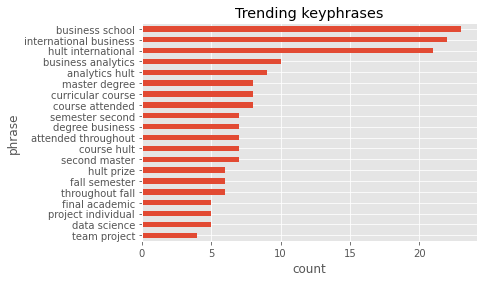

In [53]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending keyphrases')
plt.ylabel('phrase')
plt.xlabel('count')
plt.legend().set_visible(False)
plt.show()